Dataset splitting

In [1]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
# The dataset is loaded from a CSV file named 'diabetes.csv'
data = pd.read_csv('./datasets/diabetes.csv')

# Check for missing values
# Display the count of missing values in each column
print(data.isnull().sum())

# Split the data into features and target
# Separate the features (X) from the target (y)
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Split the data into train, validation, and test sets
# The data is split into 70% training and 30% temporary (X_temp, y_temp)
# The temporary set is further split into 50% validation and 50% test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reset indices of the feature and target DataFrames
X_train_df = X_train.reset_index(drop=True)
X_val_df = X_val.reset_index(drop=True)
X_test_df = X_test.reset_index(drop=True)

y_train_df = y_train.reset_index(drop=True)
y_val_df = y_val.reset_index(drop=True)
y_test_df = y_test.reset_index(drop=True)

# Save the datasets as CSV files
# Combine the feature DataFrames with their corresponding target variables
# Save the combined DataFrames as CSV files for training, validation, and testing
train_data = pd.concat([X_train_df, y_train_df], axis=1)
train_data.head()
val_data = pd.concat([X_val_df, y_val_df], axis=1)
val_data.head()
test_data = pd.concat([X_test_df, y_test_df], axis=1)
test_data.head()
train_data.to_csv('./datasets/train_data_not_scaled.csv', index=False)
val_data.to_csv('./datasets/val_data_not_scaled.csv', index=False)
test_data.to_csv('./datasets/test_data_not_scaled.csv', index=False)


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


Model Training

In [2]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import xgboost as xgb
import pickle

# Create a DMatrix for training, validation, and test data
# DMatrix is an optimized data structure that XGBoost uses to train and predict
dtrain = xgb.DMatrix(data=X_train.to_numpy(), label=y_train)
dval = xgb.DMatrix(data=X_val.to_numpy(), label=y_val)
dtest = xgb.DMatrix(data=X_test.to_numpy(), label=y_test)

# Set the hyperparameters for the XGBoost model
params = {"colsample_bytree": 0.8247176589617523, 
          "gamma": 0.30255939244569324, 
          "learning_rate": 0.07102942639067696, 
          "max_depth": 9, 
          "subsample": 0.8171213407907597, 
          "eval_metric": "auc"}

num_round = 100  # Number of boosting rounds
# Train the model with the best parameters
evallist = [(dval, 'eval')]  # Evaluation set
bst = xgb.train(params, dtrain, num_round, evals=evallist, early_stopping_rounds=10)

# Evaluate the model on the test set
preds = bst.predict(dtest)  # Predict probabilities
predictions = [round(value) for value in preds]  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, preds)
logloss = log_loss(y_test, preds)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")

# Save the model in JSON format
bst.save_model('./models/diabetes_xgb_model_proofs.json')
print("Model trained and evaluated successfully!")

# Save the model using pickle
with open('./models/diabetes_xgb_model_proofs.pkl', 'wb') as f:
    pickle.dump(bst, f)


[0]	eval-auc:0.66771
[1]	eval-auc:0.72332
[2]	eval-auc:0.75901
[3]	eval-auc:0.76975
[4]	eval-auc:0.76386
[5]	eval-auc:0.76698
[6]	eval-auc:0.76091
[7]	eval-auc:0.77062
[8]	eval-auc:0.76784
[9]	eval-auc:0.76646
[10]	eval-auc:0.76369
[11]	eval-auc:0.76923
[12]	eval-auc:0.77755
[13]	eval-auc:0.77755
[14]	eval-auc:0.77581
[15]	eval-auc:0.78170
[16]	eval-auc:0.78933
[17]	eval-auc:0.78760
[18]	eval-auc:0.78621
[19]	eval-auc:0.79071
[20]	eval-auc:0.78621
[21]	eval-auc:0.78725
[22]	eval-auc:0.78933
[23]	eval-auc:0.78586
[24]	eval-auc:0.78517
[25]	eval-auc:0.78552
[26]	eval-auc:0.78552
[27]	eval-auc:0.78725
[28]	eval-auc:0.78552
[29]	eval-auc:0.78482
Accuracy: 0.7845
ROC AUC: 0.8214
Log Loss: 0.5025
Model trained and evaluated successfully!


Accuracy: 0.7845
ROC AUC: 0.8214
Log Loss: 0.5025

In [3]:
feature_importances = bst.get_score(importance_type='weight')

# Sort features by importance
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
sorted_features

[('f1', 116.0),
 ('f5', 115.0),
 ('f6', 103.0),
 ('f2', 85.0),
 ('f7', 80.0),
 ('f4', 72.0),
 ('f0', 64.0),
 ('f3', 43.0)]

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import xgboost as xgb
import pickle

# Load the model
with open('./models/diabetes_xgb_model_proofs.pkl', 'rb') as f:
    bst = pickle.load(f)

# Function to simulate covariate shift by adding noise
def simulate_covariate_shift(X, shift_levels, shift_features=None):
    np.random.seed(0)
    if shift_features is None:
        shift_features = X.columns
    
    shifted_datasets = {}  # To store datasets with different shift levels
    
    for level in shift_levels:
        X_shifted = X.copy()
        for feature in shift_features:
            feature_std = X[feature].std()  # Calculate the standard deviation of the feature
            shift_intensity = level * feature_std  # Scale the noise by the shift level and the feature's std deviation
            shift = np.random.normal(loc=0, scale=shift_intensity, size=X[feature].shape)
            X_shifted[feature] += shift
        shifted_datasets[level] = X_shifted
    
    return shifted_datasets

# Select features to shift (for example, 'Glucose', 'BMI', 'DiabetesPedigreeFunction')
shift_features = ['Glucose', 'BMI', 'DiabetesPedigreeFunction']

# Define different levels of noise intensity (as multiples of the standard deviation)
shift_levels = [0.5, 1, 2, 3, 4]

# Simulate covariate shift on the test set
shifted_datasets = simulate_covariate_shift(pd.DataFrame(X_test, columns=X.columns), shift_levels=shift_levels, shift_features=shift_features)

# Loop through each shifted dataset and evaluate the model
results = []

for level, X_test_shifted in shifted_datasets.items():
    # Save the shifted test set as a CSV file
    X_test_shifted_df = pd.DataFrame(X_test_shifted, columns=X.columns).reset_index(drop=True)
    y_shifted_df = y_test.reset_index(drop=True)
    
    shifted_data = pd.concat([X_test_shifted_df, y_shifted_df], axis=1)
    shifted_data.to_csv(f'./datasets/test_data_shifted_level_{level}_unscaled.csv', index=False)
    
    # Evaluate the model on the shifted test set
    dtest_shifted = xgb.DMatrix(data=X_test_shifted, label=y_test)
    preds_shifted = bst.predict(dtest_shifted)
    predictions_shifted = [round(value) for value in preds_shifted]
    
    # Calculate evaluation metrics for the shifted test set
    accuracy_shifted = accuracy_score(y_test, predictions_shifted)
    roc_auc_shifted = roc_auc_score(y_test, preds_shifted)
    logloss_shifted = log_loss(y_test, preds_shifted)
    
    # Store the results
    results.append({
        'shift_level': level,
        'accuracy': accuracy_shifted,
        'roc_auc': roc_auc_shifted,
        'log_loss': logloss_shifted
    })

# Convert the results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)
print(results_df)


   shift_level  accuracy   roc_auc  log_loss
0          0.5  0.750000  0.809812  0.509023
1          1.0  0.758621  0.786556  0.534032
2          2.0  0.663793  0.693214  0.636608
3          3.0  0.646552  0.664861  0.666614
4          4.0  0.637931  0.628544  0.701461


C:\Users\lyna\AppData\Local\Temp\ipykernel_24248\1118990010.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original[feature], label='Original', color='green', shade=True)
C:\Users\lyna\AppData\Local\Temp\ipykernel_24248\1118990010.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(shifted_1[feature], label='Shift Intensity Level 1', color='#FFD700', shade=True)  # Light Yellow
C:\Users\lyna\AppData\Local\Temp\ipykernel_24248\1118990010.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(shifted_2[feature], label='Shift Intensity Level 2', color='#DAA520', shade=True)  # Orange
C:\Users\lyna\AppData\Local\Temp\ip

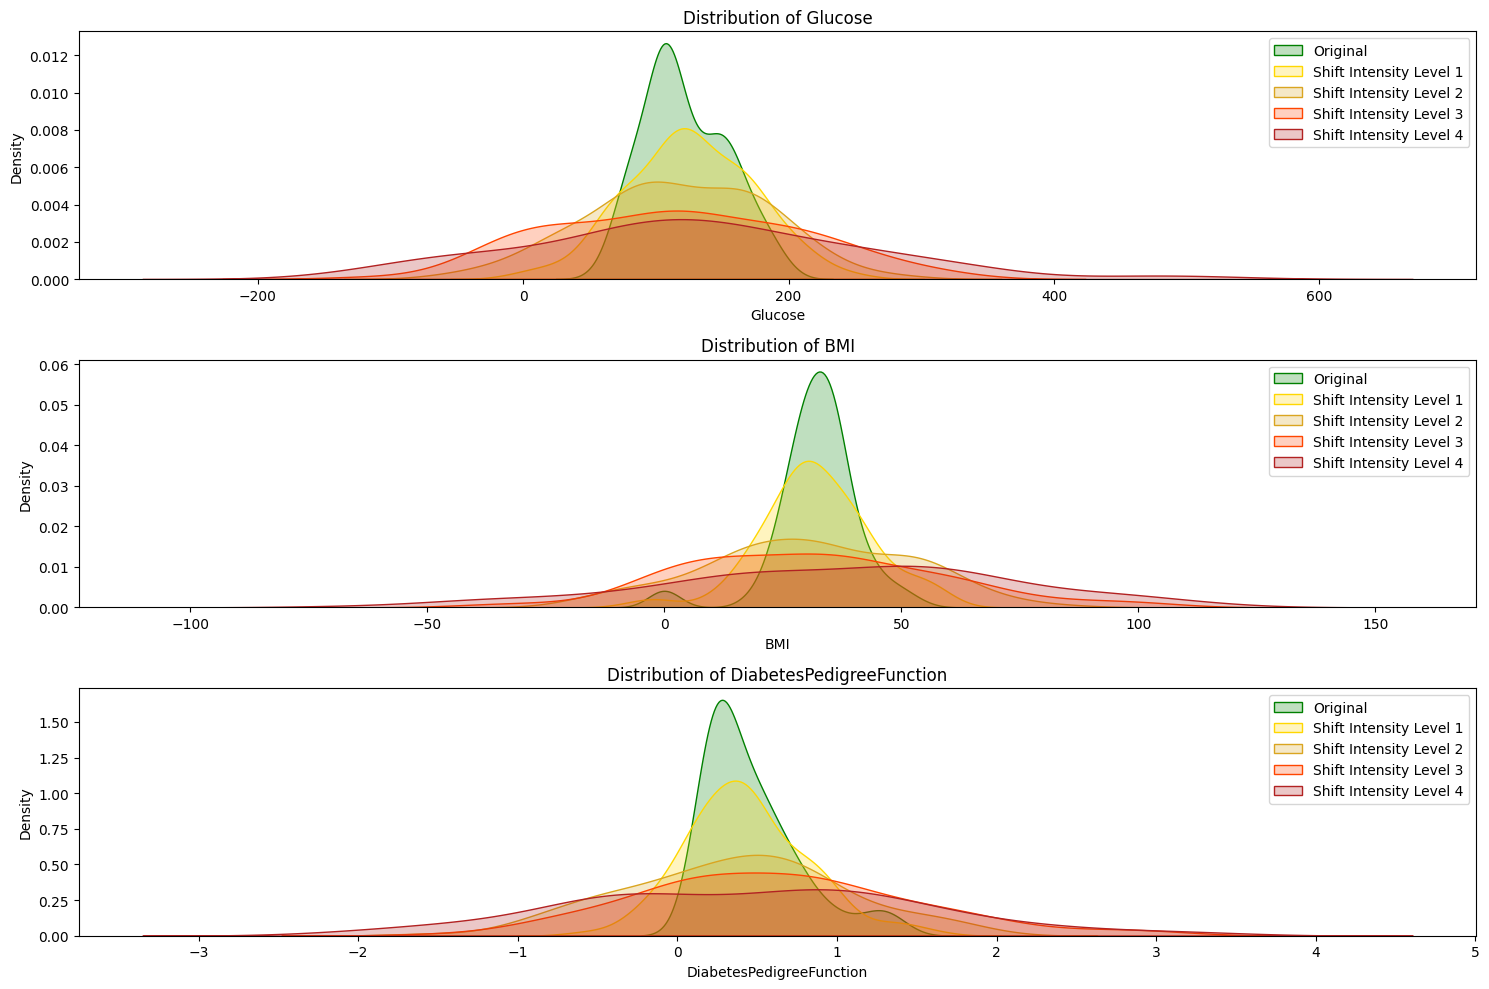

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the original and shifted datasets from CSV files
original_data = pd.read_csv('./datasets/test_data_not_scaled.csv')
shifted_1 = pd.read_csv('./datasets/test_data_shifted_level_1_unscaled.csv')
shifted_2 = pd.read_csv('./datasets/test_data_shifted_level_2_unscaled.csv')
shifted_3 = pd.read_csv('./datasets/test_data_shifted_level_3_unscaled.csv')
shifted_4 = pd.read_csv('./datasets/test_data_shifted_level_4_unscaled.csv')


# Plotting function
def plot_feature_distributions_from_csv(original, shifted_1, shifted_2, shifted_3, shifted_4, features):
    plt.figure(figsize=(15, 10))
    
    for i, feature in enumerate(features):
        plt.subplot(len(features), 1, i + 1)
        
        sns.kdeplot(original[feature], label='Original', color='green', shade=True)
        sns.kdeplot(shifted_1[feature], label='Shift Intensity Level 1', color='#FFD700', shade=True)  # Light Yellow
        sns.kdeplot(shifted_2[feature], label='Shift Intensity Level 2', color='#DAA520', shade=True)  # Orange
        sns.kdeplot(shifted_3[feature], label='Shift Intensity Level 3', color='#FF4500', shade=True)  # Dark Orange
        sns.kdeplot(shifted_4[feature], label='Shift Intensity Level 4', color='#B22222', shade=True)     # Red
        
        
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function with the features you want to compare
shift_features = ['Glucose', 'BMI', 'DiabetesPedigreeFunction']
plot_feature_distributions_from_csv(original_data, shifted_1, shifted_2, shifted_3, shifted_4, shift_features)


In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from pprint import pprint
from MED3pa.datasets import DatasetsManager
from MED3pa.models import BaseModelManager, ModelFactory
from MED3pa.detectron import DetectronExperiment
import pandas as pd
import numpy as np 

# Define different magnitudes of covariate shift to evaluate
shift_magnitudes = [1, 2, 3, 4]

# Loop through each shift magnitude, read the shifted dataset, and execute Detectron experiment
for level in shift_magnitudes:

    datasets = DatasetsManager()
    datasets.set_from_file("training", "./datasets/train_data_not_scaled.csv", "Outcome")
    datasets.set_from_file("validation", "./datasets/val_data_not_scaled.csv", "Outcome")
    datasets.set_from_file("reference", "./datasets/test_data_not_scaled.csv", "Outcome")
    
    # Load the shifted test set
    shifted_test_file = f'./datasets/test_data_shifted_level_{level}_unscaled.csv'
    datasets.set_from_file("testing", shifted_test_file, "Outcome")
    detectron_path = f'./results/detectron_experiment_{level}'

    factory = ModelFactory()
    loaded_model = factory.create_model_from_pickled("./models/diabetes_xgb_model_proofs.pkl")

    bm_manager = BaseModelManager()
    bm_manager.set_base_model(loaded_model) 

    # Run Detectron experiment
    detectron_results = DetectronExperiment.run(datasets=datasets, base_model_manager=bm_manager)
    # Print and store the results
    print(f"Results for shift magnitude: {level}")
    pprint(detectron_results.analyze_results(['original_disagreement_strategy', 'mannwhitney_strategy', 'enhanced_disagreement_strategy']))
    detectron_results.save(detectron_path)

    BaseModelManager.reset()



running seeds: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


Detectron execution on testing set completed.
Results for shift magnitude: 1
[{'Strategy': 'original_disagreement_strategy',
  'baseline_mean': 12.47,
  'baseline_std': 1.920702996301094,
  'p_value': 0.1,
  'test_statistic': 10},
 {'Strategy': 'mannwhitney_strategy',
  'p_value': 5.032694967672459e-13,
  'significance_description': {'large': 56.666666666666664,
                               'moderate': 7.777777777777778,
                               'small': 17.77777777777778,
                               'unsignificant shift': 17.77777777777778},
  'u_statistic': 1593.0},
 {'Strategy': 'enhanced_disagreement_strategy',
  'baseline_mean': 7.4,
  'baseline_std': 1.2631530214330944,
  'shift_probability': 0.9444444444444444,
  'significance_description': {'large': 56.666666666666664,
                               'moderate': 7.777777777777778,
                               'small': 17.77777777777778,
                               'unsignificant shift': 17.77777777777778},
  'tes

running seeds: 100%|██████████| 100/100 [00:23<00:00,  4.19it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:26<00:00,  3.74it/s]


Detectron execution on testing set completed.
Results for shift magnitude: 2
[{'Strategy': 'original_disagreement_strategy',
  'baseline_mean': 12.47,
  'baseline_std': 1.920702996301094,
  'p_value': 0.04,
  'test_statistic': 7},
 {'Strategy': 'mannwhitney_strategy',
  'p_value': 6.677212454421171e-17,
  'significance_description': {'large': 58.88888888888889,
                               'moderate': 18.88888888888889,
                               'small': 12.222222222222221,
                               'unsignificant shift': 10.0},
  'u_statistic': 1190.5},
 {'Strategy': 'enhanced_disagreement_strategy',
  'baseline_mean': 7.4,
  'baseline_std': 1.2631530214330944,
  'shift_probability': 0.9444444444444444,
  'significance_description': {'large': 58.88888888888889,
                               'moderate': 18.88888888888889,
                               'small': 12.222222222222221,
                               'unsignificant shift': 10.0},
  'test_statistic': 9.8111111111

running seeds: 100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Detectron execution on testing set completed.
Results for shift magnitude: 3
[{'Strategy': 'original_disagreement_strategy',
  'baseline_mean': 12.47,
  'baseline_std': 1.920702996301094,
  'p_value': 0.07,
  'test_statistic': 9},
 {'Strategy': 'mannwhitney_strategy',
  'p_value': 1.8544820023431715e-22,
  'significance_description': {'large': 84.44444444444444,
                               'moderate': 5.555555555555555,
                               'small': 3.3333333333333335,
                               'unsignificant shift': 6.666666666666667},
  'u_statistic': 690.0},
 {'Strategy': 'enhanced_disagreement_strategy',
  'baseline_mean': 7.4,
  'baseline_std': 1.2631530214330944,
  'shift_probability': 1.0,
  'significance_description': {'large': 84.44444444444444,
                               'moderate': 5.555555555555555,
                               'small': 3.3333333333333335,
                               'unsignificant shift': 6.666666666666667},
  'test_statistic': 1

running seeds: 100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


Detectron execution on testing set completed.
Results for shift magnitude: 4
[{'Strategy': 'original_disagreement_strategy',
  'baseline_mean': 12.47,
  'baseline_std': 1.920702996301094,
  'p_value': 0.43,
  'test_statistic': 12},
 {'Strategy': 'mannwhitney_strategy',
  'p_value': 2.3532136181383966e-22,
  'significance_description': {'large': 67.77777777777779,
                               'moderate': 17.77777777777778,
                               'small': 11.11111111111111,
                               'unsignificant shift': 3.3333333333333335},
  'u_statistic': 710.0},
 {'Strategy': 'enhanced_disagreement_strategy',
  'baseline_mean': 7.4,
  'baseline_std': 1.2631530214330944,
  'shift_probability': 0.9777777777777777,
  'significance_description': {'large': 67.77777777777779,
                               'moderate': 17.77777777777778,
                               'small': 11.11111111111111,
                               'unsignificant shift': 3.3333333333333335},
  'te

| Shift Magnitude | Original Disagreement Test Results | Mann Whitney Test Results                                                                                     | Improved Disagreement Test Results                                                                                  | Discovery Power (AUC)                      |
|----------------:|:-----------------------------------|:---------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------|:------------------------------------------|
|               1 | p-value : 0.39                     | p-value: 0.100 <br> shift significance: 32.22% not significant, 43.33% small, 20.00% moderate, 4.44% large      | shift probability: 0.622 <br> shift significance: 32.22% not significant, 43.33% small, 20.00% moderate, 4.44% large | power: 0.1129 <br> auc: 0.5469             |
|               2 | p-value : 0.10                     | p-value: 4.52e-13 <br> shift significance: 10.00% not significant, 22.22% small, 51.11% moderate, 16.67% large  | shift probability: 0.800 <br> shift significance: 10.00% not significant, 22.22% small, 51.11% moderate, 16.67% large| power: 0.2600 <br> auc: 0.7622             |
|               3 | p-value : 0.23                     | p-value: 3.33e-11 <br> shift significance: 10.00% not significant, 31.11% small, 35.56% moderate, 23.33% large  | shift probability: 0.800 <br> shift significance: 10.00% not significant, 31.11% small, 35.56% moderate, 23.33% large| power: 0.3029 <br> auc: 0.7436             |
|               4 | p-value : 0.03                     | p-value: 7.80e-30 <br> shift significance: 0% not significant, 1.11% small, 23.33% moderate, 75.56% large       | shift probability: 1.000 <br> shift significance: 0% not significant, 1.11% small, 23.33% moderate, 75.56% large     | power: 0.7757 <br> auc: 0.9602             |


In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load the JSON files
with open('./results/detectron_experiment_1/rejection_counts.json', 'r') as file:
    data1 = json.load(file)

with open('./results/detectron_experiment_2/rejection_counts.json', 'r') as file:
    data2 = json.load(file)

with open('./results/detectron_experiment_3/rejection_counts.json', 'r') as file:
    data3 = json.load(file)

with open('./results/detectron_experiment_4/rejection_counts.json', 'r') as file:
    data4 = json.load(file)

# Save the arrays to variables
reference_counts = data1['reference']
test_counts1 = data1['test']
test_counts2 = data2['test']
test_counts3 = data3['test']
test_counts4 = data4['test']

# Set the style using seaborn
sns.set(style="whitegrid")

# Plot the data
plt.figure(figsize=(12, 8))

# Plot reference counts
sns.lineplot(data=reference_counts, label='Reference', color='green', linewidth=2.5)

# Plot test counts with different shift levels
sns.lineplot(data=test_counts1, label='Shift Intensity Level 1', color='#FFD700', linewidth=2.5)
sns.lineplot(data=test_counts2, label='Shift Intensity Level 2', color='#DAA520', linewidth=2.5)
sns.lineplot(data=test_counts3, label='Shift Intensity Level 3', color='#FF4500', linewidth=2.5)
sns.lineplot(data=test_counts4, label='Shift Intensity Level 4', color='#B22222', linewidth=2.5)

# Add titles and labels
plt.title('Rejection Counts: Reference vs Test', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Rejection count', fontsize=14)

# Adjust legend and plot appearance
plt.legend(title='Legend', fontsize=12, title_fontsize='13')
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data extracted from the table
data = {
    "Shift Magnitude": [1, 2, 3, 4],
    "Original Disagreement p-value": [0.02, 0.07, 0.1, 0.1],
    "Mann Whitney p-value": [0.123, 7.08e-14, 3.62e-14, 5.53e-31],
    "Enhanced Disagreement Probability": [0.577, 0.944, 0.944, 1.0],
    "Significant Large": [17.78, 56.67, 47.78, 100.0],
    "Significant Moderate": [15.56, 11.11, 23.33, 0.0],
    "Significant Small": [17.78, 13.33, 12.22, 0.0],
    "Not Significant": [48.89, 18.89, 16.67, 0.0]
}

df = pd.DataFrame(data)

# Set the style
sns.set(style="whitegrid")

# Plotting Original Disagreement p-values
plt.figure(figsize=(10, 6))
sns.lineplot(x="Shift Magnitude", y="Original Disagreement p-value", data=df, marker='o', color='blue')
plt.yscale('log')  # Log scale for better visibility of small p-values
plt.title('Original Disagreement p-values by Shift Magnitude')
plt.ylabel('P-value (log scale)')
plt.xlabel('Shift Magnitude')
plt.grid(True)
plt.show()

# Plotting Mann Whitney p-values
plt.figure(figsize=(10, 6))
sns.lineplot(x="Shift Magnitude", y="Mann Whitney p-value", data=df, marker='o', color='orange')
plt.yscale('log')  # Log scale for better visibility of small p-values
plt.title('Mann Whitney p-values by Shift Magnitude')
plt.ylabel('P-value (log scale)')
plt.xlabel('Shift Magnitude')
plt.grid(True)
plt.show()

# Plotting Enhanced Disagreement Probability
plt.figure(figsize=(10, 6))
sns.lineplot(x="Shift Magnitude", y="Enhanced Disagreement Probability", data=df, marker='o', color='green')
plt.title('Enhanced Disagreement Shift Probability by Shift Magnitude')
plt.ylabel('Shift Probability')
plt.xlabel('Shift Magnitude')
plt.grid(True)
plt.show()

# Plotting significance descriptions
plt.figure(figsize=(10, 6))
sns.lineplot(x="Shift Magnitude", y="Significant Large", data=df, marker='o', color='red', label='Large')
sns.lineplot(x="Shift Magnitude", y="Significant Moderate", data=df, marker='o', color='orange', label='Moderate')
sns.lineplot(x="Shift Magnitude", y="Significant Small", data=df, marker='o', color='yellow', label='Small')
sns.lineplot(x="Shift Magnitude", y="Not Significant", data=df, marker='o', color='green', label='Not Significant')
plt.title('Shift Significance by Shift Magnitude')
plt.ylabel('Percentage (%)')
plt.xlabel('Shift Magnitude')
plt.legend()
plt.grid(True)
plt.show()


In [1]:

import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from pprint import pprint
from MED3pa.datasets import DatasetsManager
from MED3pa.models import BaseModelManager, ModelFactory
from MED3pa.detectron import DetectronExperiment
import pandas as pd
import numpy as np 

# Define different magnitudes of covariate shift to evaluate
shift_magnitudes = [0.5, 1, 2, 3, 4]

level = 0.5
datasets = DatasetsManager()
datasets.set_from_file("training", "./datasets/train_data_not_scaled.csv", "Outcome")
datasets.set_from_file("validation", "./datasets/val_data_not_scaled.csv", "Outcome")
datasets.set_from_file("reference", "./datasets/test_data_not_scaled.csv", "Outcome")

# Load the shifted test set
shifted_test_file = f'./datasets/test_data_shifted_level_{level}_unscaled.csv'
datasets.set_from_file("testing", shifted_test_file, "Outcome")
detectron_path = f'./results/detectron_experiment_{level}'

factory = ModelFactory()
loaded_model = factory.create_model_from_pickled("./models/diabetes_xgb_model_proofs.pkl")

bm_manager = BaseModelManager()
bm_manager.set_base_model(loaded_model) 

# Run Detectron experiment
detectron_results = DetectronExperiment.run(datasets=datasets, base_model_manager=bm_manager)
# Print and store the results
print(f"Results for shift magnitude: {level}")
pprint(detectron_results.analyze_results(['original_disagreement_strategy', 'mannwhitney_strategy', 'enhanced_disagreement_strategy']))
detectron_results.save(detectron_path)

BaseModelManager.reset()

running seeds: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


Detectron execution on testing set completed.
Results for shift magnitude: 0.5
[{'Strategy': 'original_disagreement_strategy',
  'baseline_mean': 12.47,
  'baseline_std': 1.920702996301094,
  'p_value': 0.05,
  'test_statistic': 8},
 {'Strategy': 'mannwhitney_strategy',
  'p_value': 0.8690771972982618,
  'significance_description': {'large': 6.666666666666667,
                               'moderate': 17.77777777777778,
                               'small': 20.0,
                               'unsignificant shift': 55.55555555555556},
  'u_statistic': 4434.0},
 {'Strategy': 'enhanced_disagreement_strategy',
  'baseline_mean': 7.4,
  'baseline_std': 1.2631530214330944,
  'shift_probability': 0.5777777777777777,
  'significance_description': {'large': 6.666666666666667,
                               'moderate': 17.77777777777778,
                               'small': 20.0,
                               'unsignificant shift': 55.55555555555556},
  'test_statistic': 7.1333333333333

In [1]:

import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from pprint import pprint
from MED3pa.datasets import DatasetsManager
from MED3pa.models import BaseModelManager, ModelFactory
from MED3pa.detectron import DetectronExperiment
import pandas as pd
import numpy as np 

# Define different magnitudes of covariate shift to evaluate
shift_magnitudes = [0.5, 1, 2, 3, 4]

level = 1
datasets = DatasetsManager()
datasets.set_from_file("training", "./datasets/train_data_not_scaled.csv", "Outcome")
datasets.set_from_file("validation", "./datasets/val_data_not_scaled.csv", "Outcome")
datasets.set_from_file("reference", "./datasets/test_data_not_scaled.csv", "Outcome")

# Load the shifted test set
shifted_test_file = f'./datasets/test_data_shifted_level_{level}_unscaled.csv'
datasets.set_from_file("testing", shifted_test_file, "Outcome")
detectron_path = f'./results/detectron_experiment_{level}'

factory = ModelFactory()
loaded_model = factory.create_model_from_pickled("./models/diabetes_xgb_model_proofs.pkl")

bm_manager = BaseModelManager()
bm_manager.set_base_model(loaded_model) 

# Run Detectron experiment
detectron_results = DetectronExperiment.run(datasets=datasets, base_model_manager=bm_manager)
# Print and store the results
print(f"Results for shift magnitude: {level}")
pprint(detectron_results.analyze_results(['original_disagreement_strategy', 'mannwhitney_strategy', 'enhanced_disagreement_strategy']))
detectron_results.save(detectron_path)

BaseModelManager.reset()

running seeds: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Detectron execution on testing set completed.
Results for shift magnitude: 1
[{'Strategy': 'original_disagreement_strategy',
  'baseline_mean': 12.47,
  'baseline_std': 1.920702996301094,
  'p_value': 0.1,
  'test_statistic': 10},
 {'Strategy': 'mannwhitney_strategy',
  'p_value': 5.032694967672459e-13,
  'significance_description': {'large': 56.666666666666664,
                               'moderate': 7.777777777777778,
                               'small': 17.77777777777778,
                               'unsignificant shift': 17.77777777777778},
  'u_statistic': 1593.0},
 {'Strategy': 'enhanced_disagreement_strategy',
  'baseline_mean': 7.4,
  'baseline_std': 1.2631530214330944,
  'shift_probability': 0.9444444444444444,
  'significance_description': {'large': 56.666666666666664,
                               'moderate': 7.777777777777778,
                               'small': 17.77777777777778,
                               'unsignificant shift': 17.77777777777778},
  'tes

In [ ]:

import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from pprint import pprint
from MED3pa.datasets import DatasetsManager
from MED3pa.models import BaseModelManager, ModelFactory
from MED3pa.detectron import DetectronExperiment
import pandas as pd
import numpy as np 

# Define different magnitudes of covariate shift to evaluate
shift_magnitudes = [0.5, 1, 2, 3, 4]

level = 2
datasets = DatasetsManager()
datasets.set_from_file("training", "./datasets/train_data_not_scaled.csv", "Outcome")
datasets.set_from_file("validation", "./datasets/val_data_not_scaled.csv", "Outcome")
datasets.set_from_file("reference", "./datasets/test_data_not_scaled.csv", "Outcome")

# Load the shifted test set
shifted_test_file = f'./datasets/test_data_shifted_level_{level}_unscaled.csv'
datasets.set_from_file("testing", shifted_test_file, "Outcome")
detectron_path = f'./results/detectron_experiment_{level}'

factory = ModelFactory()
loaded_model = factory.create_model_from_pickled("./models/diabetes_xgb_model_proofs.pkl")

bm_manager = BaseModelManager()
bm_manager.set_base_model(loaded_model) 

# Run Detectron experiment
detectron_results = DetectronExperiment.run(datasets=datasets, base_model_manager=bm_manager)
# Print and store the results
print(f"Results for shift magnitude: {level}")
pprint(detectron_results.analyze_results(['original_disagreement_strategy', 'mannwhitney_strategy', 'enhanced_disagreement_strategy']))
detectron_results.save(detectron_path)

BaseModelManager.reset()

In [ ]:

import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from pprint import pprint
from MED3pa.datasets import DatasetsManager
from MED3pa.models import BaseModelManager, ModelFactory
from MED3pa.detectron import DetectronExperiment
import pandas as pd
import numpy as np 

# Define different magnitudes of covariate shift to evaluate
shift_magnitudes = [0.5, 1, 2, 3, 4]

level = 3
datasets = DatasetsManager()
datasets.set_from_file("training", "./datasets/train_data_not_scaled.csv", "Outcome")
datasets.set_from_file("validation", "./datasets/val_data_not_scaled.csv", "Outcome")
datasets.set_from_file("reference", "./datasets/test_data_not_scaled.csv", "Outcome")

# Load the shifted test set
shifted_test_file = f'./datasets/test_data_shifted_level_{level}_unscaled.csv'
datasets.set_from_file("testing", shifted_test_file, "Outcome")
detectron_path = f'./results/detectron_experiment_{level}'

factory = ModelFactory()
loaded_model = factory.create_model_from_pickled("./models/diabetes_xgb_model_proofs.pkl")

bm_manager = BaseModelManager()
bm_manager.set_base_model(loaded_model) 

# Run Detectron experiment
detectron_results = DetectronExperiment.run(datasets=datasets, base_model_manager=bm_manager)
# Print and store the results
print(f"Results for shift magnitude: {level}")
pprint(detectron_results.analyze_results(['original_disagreement_strategy', 'mannwhitney_strategy', 'enhanced_disagreement_strategy']))
detectron_results.save(detectron_path)

BaseModelManager.reset()

In [ ]:

import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from pprint import pprint
from MED3pa.datasets import DatasetsManager
from MED3pa.models import BaseModelManager, ModelFactory
from MED3pa.detectron import DetectronExperiment
import pandas as pd
import numpy as np 

# Define different magnitudes of covariate shift to evaluate
shift_magnitudes = [0.5, 1, 2, 3, 4]

level = 4
datasets = DatasetsManager()
datasets.set_from_file("training", "./datasets/train_data_not_scaled.csv", "Outcome")
datasets.set_from_file("validation", "./datasets/val_data_not_scaled.csv", "Outcome")
datasets.set_from_file("reference", "./datasets/test_data_not_scaled.csv", "Outcome")

# Load the shifted test set
shifted_test_file = f'./datasets/test_data_shifted_level_{level}_unscaled.csv'
datasets.set_from_file("testing", shifted_test_file, "Outcome")
detectron_path = f'./results/detectron_experiment_{level}'

factory = ModelFactory()
loaded_model = factory.create_model_from_pickled("./models/diabetes_xgb_model_proofs.pkl")

bm_manager = BaseModelManager()
bm_manager.set_base_model(loaded_model) 

# Run Detectron experiment
detectron_results = DetectronExperiment.run(datasets=datasets, base_model_manager=bm_manager)
# Print and store the results
print(f"Results for shift magnitude: {level}")
pprint(detectron_results.analyze_results(['original_disagreement_strategy', 'mannwhitney_strategy', 'enhanced_disagreement_strategy']))
detectron_results.save(detectron_path)

BaseModelManager.reset()